In [11]:
import concurrent.futures
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# ARK's daily trades
TRADES_DATE = "2021-02-03"
DELTA = 1

year, month, day = TRADES_DATE.split("-")
files = list(Path(f"./trades/").glob(f"ARK_Trade_{''.join([month, day, year])}_*.csv"))
if len(files)>1:
    raise ValueError("more than 1 file for the given date")
    
trades = pd.read_csv(
    files[0],
    header=3,
    usecols=["FUND", "Date", "Direction", "Ticker", "CUSIP", "Name", "Shares", "% of ETF"]
)
trades.columns = trades.columns.map(lambda x:x.lower())
trades.sort_values("ticker", inplace=True)
print(trades.shape)
trades.head()

(18, 8)


,fund,date,direction,ticker,cusip,name,shares,% of etf
15,ARKQ,2021-02-03,Sell,AVAV,8073108,AEROVIRONMENT INC,13095,0.0484
13,ARKQ,2021-02-03,Sell,BYDDY,05606L100,BYD CO LTD,31150,0.0652
16,ARKK,2021-02-03,Buy,FATE,31189P102,FATE THERAPEUTICS INC,98059,0.0394
12,ARKQ,2021-02-03,Sell,FLIR,302445101,FLIR SYSTEMS INC,50496,0.0842
9,ARKQ,2021-02-03,Sell,MTLS,57667T100,MATERIALISE NV,47430,0.1039


In [13]:
# open prices of traded stocks
open_configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Open"} for ticker in trades["ticker"].unique()] # on ark's trade date

def parallel_fetch_daily_data(config):
    try:
        # fetch daily market data from yahoo finance
        df = web.get_data_yahoo(config["ticker"], start=config["date"], end=config["date"])[[config["on"]]]
        df["ticker"] = config["ticker"]
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)


open_prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    open_prices.extend(executor.map(parallel_fetch_daily_data, open_configs))
open_prices = pd.concat(open_prices)
open_prices.reset_index(inplace=True)
open_prices.set_index("ticker", inplace=True)
print(open_prices.shape)
open_prices.head()

(16, 2)


,Date,Open
ticker,,
AVAV,2021-02-03,119.000000
BYDDY,2021-02-03,70.599998
FATE,2021-02-03,99.199997
FLIR,2021-02-03,54.259998
MTLS,2021-02-03,72.989998


In [14]:
# net & volume of trades (assume on open price)
net = trades.copy()[["ticker", "shares", "direction"]]
net["shares"] = net.apply(lambda row:row["shares"] if row["direction"]=="Buy" else -row["shares"], axis=1)
net = net.groupby("ticker").sum()

net = net.join(open_prices, how="inner") # link to price

net["signal"] = net["shares"].apply(lambda x: "Buy" if x>0 else "Sell")
net["volume"] = net["shares"] * net["Open"]
net["abs_volume"] = abs(net["volume"])

net.sort_values("abs_volume", ascending=False, inplace=True)
print(net.shape)
net.head(30)

(16, 6)


,shares,Date,Open,signal,volume,abs_volume
ticker,,,,,,
SPOT,503728,2021-02-03,321.500000,Buy,1.619486e+08,1.619486e+08
TER,294043,2021-02-03,123.470001,Buy,3.630549e+07,3.630549e+07
SPLK,-173800,2021-02-03,177.289993,Sell,-3.081300e+07,3.081300e+07
PCAR,318474,2021-02-03,92.900002,Buy,2.958624e+07,2.958624e+07
NVS,299907,2021-02-03,89.349998,Buy,2.679669e+07,2.679669e+07
ROKU,-53551,2021-02-03,422.494995,Sell,-2.262503e+07,2.262503e+07
TWST,-97415,2021-02-03,196.750000,Sell,-1.916640e+07,1.916640e+07
VRTX,57100,2021-02-03,218.419998,Buy,1.247178e+07,1.247178e+07
FATE,98059,2021-02-03,99.199997,Buy,9.727453e+06,9.727453e+06


In [15]:
FUTURE_DATE = datetime.strptime(TRADES_DATE, '%Y-%m-%d') + timedelta(days=DELTA)

# on ark's trades date
configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()]
# future date
configs.extend([{"ticker":ticker, "date":FUTURE_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()])

prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
print(prices.shape)
prices.tail(3)

(32, 2)


,Adj Close,ticker
Date,,
2021-02-04,125.519997,TER
2021-02-04,197.649994,TWST
2021-02-04,213.710007,VRTX


In [16]:
returns = [] # actual price changes
gg = prices.groupby("ticker")
for g in gg.groups:
    gdf = gg.get_group(g)
    if len(gdf)>2:
        raise ValueError("records exceed 2. can only compare 2 records")
    ticker_return = gdf["Adj Close"].pct_change().loc[FUTURE_DATE]
    returns.append({
        "ticker":g,
        "return":ticker_return,
        "actual":"Buy" if ticker_return > 0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns.set_index("ticker", inplace=True)
returns.head(3)

,return,actual
ticker,,
AVAV,0.005039,Buy
BYDDY,-0.029139,Sell
FATE,0.044585,Buy


In [17]:
df = net.join(returns).sort_values("abs_volume", ascending=False)
df.head(50)

,shares,Date,Open,signal,volume,abs_volume,return,actual
ticker,,,,,,,,
SPOT,503728,2021-02-03,321.500000,Buy,1.619486e+08,1.619486e+08,-0.008038,Sell
TER,294043,2021-02-03,123.470001,Buy,3.630549e+07,3.630549e+07,0.041055,Buy
SPLK,-173800,2021-02-03,177.289993,Sell,-3.081300e+07,3.081300e+07,0.005663,Buy
PCAR,318474,2021-02-03,92.900002,Buy,2.958624e+07,2.958624e+07,0.014947,Buy
NVS,299907,2021-02-03,89.349998,Buy,2.679669e+07,2.679669e+07,0.014439,Buy
ROKU,-53551,2021-02-03,422.494995,Sell,-2.262503e+07,2.262503e+07,0.017903,Buy
TWST,-97415,2021-02-03,196.750000,Sell,-1.916640e+07,1.916640e+07,0.040482,Buy
VRTX,57100,2021-02-03,218.419998,Buy,1.247178e+07,1.247178e+07,0.012844,Buy
FATE,98059,2021-02-03,99.199997,Buy,9.727453e+06,9.727453e+06,0.044585,Buy


<Figure size 720x504 with 0 Axes>

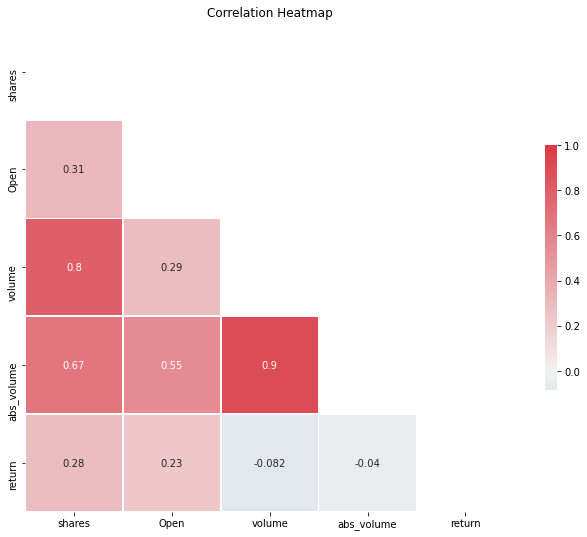

In [18]:
# correlation heatmap
plt.figure(figsize=(10,7))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Correlation Heatmap");

              precision    recall  f1-score   support

         Buy       0.83      0.42      0.56        12
        Sell       0.30      0.75      0.43         4

    accuracy                           0.50        16
   macro avg       0.57      0.58      0.49        16
weighted avg       0.70      0.50      0.52        16



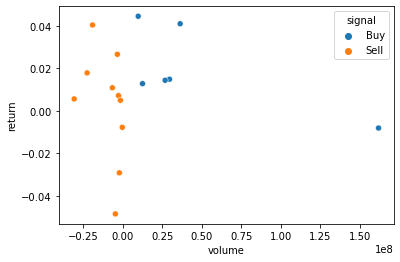

In [19]:
print(classification_report(df["actual"], df["signal"]))
sns.scatterplot(x=df["volume"], y=df["return"], hue=df["signal"])

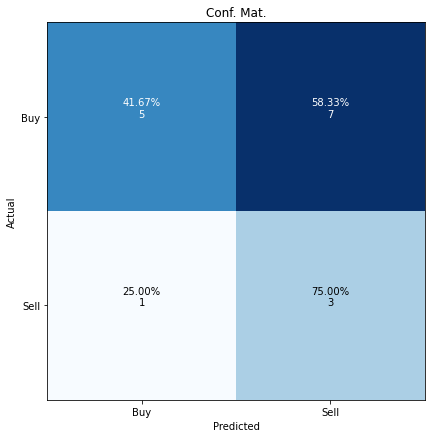

In [20]:
def plot_confusion_matrix_(cm, target_names, title='Conf. Mat.', normalize=True, saveit=False, showit=True):
    import itertools
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     thresh = cm_norm.max() / 1.5 if normalize else cm.max() / 2
    thresh =  cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, 
                     "{:0.2f}%\n{:,}".format(100*cm_norm[i, j], cm[i, j]),
                     horizontalalignment="center",
                     # color="white" if cm_norm[i, j] > thresh else "black",
                     color="white" if cm[i, j] > thresh else "black",
                    )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if saveit:
        plt.savefig(fname=saveit)
    if showit:
        plt.show()
plot_confusion_matrix_(confusion_matrix(df["actual"], df["signal"]), ["Buy", "Sell"])